# Data Science

Debido al requerimiento del cliente, se procederan a reordenar la data, para obtener un set de datos horarios donde cada fila represente la cantidad de viajes realizados en esa hora en especifico(hora de comienzo del viaje).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet('Data\process_taxis.parquet',engine='pyarrow')

In [3]:
df.set_index(keys='pickup_datetime',inplace=True)

In [4]:
df.index

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 00:00:05',
               '2023-01-01 00:00:06', '2023-01-01 00:00:08',
               '2023-01-01 00:00:09', '2023-01-01 00:00:18',
               '2023-01-01 00:00:47', '2023-01-01 00:00:52',
               '2023-01-01 00:01:07', '2023-01-01 00:01:08',
               ...
               '2024-06-30 23:59:49', '2024-06-30 23:59:49',
               '2024-06-30 23:59:51', '2024-06-30 23:59:51',
               '2024-06-30 23:59:54', '2024-06-30 23:59:54',
               '2024-06-30 23:59:55', '2024-06-30 23:59:56',
               '2024-07-01 00:00:27', '2024-07-01 00:05:23'],
              dtype='datetime64[us]', name='pickup_datetime', length=47089377, freq=None)

In [46]:
# Crear un nuevo DataFrame con la cantidad de registros por hora
df_hour = df.resample('30min').size().to_frame('travels')

In [36]:
df_hour.tail(2)

,travels
pickup_datetime,
2024-06-30 23:30:00,818
2024-07-01 00:00:00,2


### <center>Models</center>

Para cumplir con las expectativas del cliente, se evaluaran 2 modelos

- Forecaster Autoregresive: 

Para modelar la evolución de los datos como serie de tiempo, se optó por un modelo Forecaster Autoregresivo que incorpora lags de la variable objetivo y variables de tiempo (como la hora, mes, dia, etc). Esta elección se fundamenta en la hipótesis de que los valores futuros de la serie están fuertemente influenciados por sus valores pasados y por patrones estacionales o cíclicos asociados a las variables de tiempo.

Los lags permiten capturar la autocorrelación presente en la serie, mientras que las variables de tiempo ayudan a modelar los componentes estacionales y de tendencia, lo que resulta en predicciones más precisas y robustas.
Luego de esto se evaluara el desempeño del modelo para su comparacion.

- Modelo de Predicción en Cascada(Autoregresion y Random Forest o regresion lineal multiple):

Para realizar predicciones futuras de la variable objetivo, el modelo se desarrollará en dos etapas. En la primera etapa, se utilizarán modelos predictivos para estimar los valores futuros de las variables auxiliares (ganancia neta, duración del viaje, y CO₂ emitido). Estas estimaciones serán generadas únicamente a partir de valores pasados de cada una de las variables auxiliares, aplicando un modelo autoregresivo puro. Así, para cada variable auxiliar, se entrenará un modelo autoregresivo independiente que capture las tendencias y patrones de su serie temporal individual sin depender de otras variables.

En la segunda etapa, las estimaciones futuras de estas variables auxiliares se utilizarán como entradas (features) en el modelo final. Este modelo tendrá como objetivo principal la predicción de la variable objetivo y empleará tanto los valores estimados de las variables auxiliares como el valor pasado de la variable objetivo para optimizar su precisión en las predicciones futuras. 

******

### <center>Target</center>

El desafio al cual nos ha sometido el cliente, es predecir la demanda de taxis, para lo cual es necesario saber o estimar un valor de cuantos viajes pudieran llegar a realizarse. Por lo cual, se utilizara como target la columna "viajes" creada a partir del recuento de instancias de nuestra data principal transformada en un dataframe con frecuencia horaria.



In [37]:
df.columns

Index(['dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID',
       'DOLocationID', 'total_price', 'service', 'fuel_type',
       'energy_consumption', 'fuel_cost', 'trip_duration', 'labor', 'co2',
       'maintenance', 'net_profit'],
      dtype='object')

In [47]:
sum_for_price = df['total_price'].resample('30min').sum().to_frame('total_price')
sum_for_cost = df['fuel_cost'].resample('30min').sum().to_frame('fuel_cost')
sum_for_profit = df['net_profit'].resample('30min').sum().to_frame('net_profit')
sum_for_duration = df['trip_duration'].resample('30min').sum().to_frame('trip_duration')
sum_for_distance = df['trip_distance'].resample('30min').sum().to_frame('trip_distance')
sum_for_co2 = df['co2'].resample('30min').sum().to_frame('co2')

In [48]:
# Unir los resultados en un solo DataFrame
df_hour = df_hour.join([sum_for_price,sum_for_cost,sum_for_profit,sum_for_duration,sum_for_distance,sum_for_co2])

In [49]:
df_hour

,travels,total_price,fuel_cost,net_profit,trip_duration,trip_distance,co2
pickup_datetime,,,,,,,
2023-01-01 00:00:00,1853,47979.22,395.191741,40904.556504,406.908889,6846.976,9817.18336
2023-01-01 00:30:00,2517,66286.79,576.180912,56303.368866,568.035556,9762.960,14440.97440
2023-01-01 01:00:00,2319,62007.80,544.498246,52805.492954,518.825000,9239.184,13659.14928
2023-01-01 01:30:00,2224,58375.04,546.593933,49788.835101,470.569167,9017.136,13945.24736
2023-01-01 02:00:00,2035,53229.55,505.169056,45693.233555,404.129722,8479.472,12784.88160
...,...,...,...,...,...,...,...
2024-06-30 22:00:00,1337,31547.81,279.424093,26865.990574,262.873333,4667.760,7117.63936
2024-06-30 22:30:00,1158,27133.76,242.651104,23144.853607,222.342222,4145.312,6112.94160
2024-06-30 23:00:00,902,21163.91,199.414637,18051.228108,170.396389,3411.280,4942.79536


In [50]:
df_hour.reset_index(inplace=True)
df_hour['year'] = df_hour['pickup_datetime'].dt.year
df_hour['quarter'] = df_hour['pickup_datetime'].dt.quarter
df_hour['month'] = df_hour['pickup_datetime'].dt.month
df_hour['day_month'] = df_hour['pickup_datetime'].dt.day
df_hour['weekday'] = df_hour['pickup_datetime'].dt.dayofweek
df_hour['hour'] = df_hour['pickup_datetime'].dt.hour
df_hour['weekend'] = df_hour['pickup_datetime'].apply(lambda x: x.weekday() < 5).astype(int) # 1 = weekday, 0 = weekend
#df_hour.drop(columns=['pickup_datetime','dropoff_datetime'],inplace=True)
df_hour.set_index(keys='pickup_datetime',inplace=True)

# Correlation

Antes de comenzar a implementar los modelos, analizaremos las correlaciones y autocorrelaciones de las diversas variables.

Como nuestro target es la cantidad de viajes realizados en ese determinado momento(ya sea por hora o media hora) se procederan a analizar las correlaciones de esa variable con las variables de tiempo y tambien con nuestras otras variables.

In [52]:
df_hour.columns

Index(['travels', 'total_price', 'fuel_cost', 'net_profit', 'trip_duration',
       'trip_distance', 'co2', 'year', 'quarter', 'month', 'day_month',
       'weekday', 'hour', 'weekend'],
      dtype='object')

#### Time variables

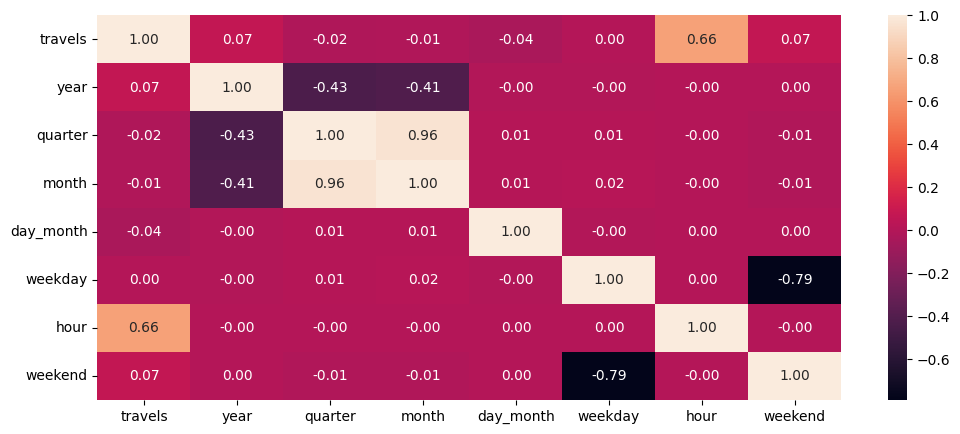

In [53]:
corr = df_hour[['travels', 'year', 'quarter', 'month', 'day_month',
       'weekday', 'hour', 'weekend']].corr(method='spearman')
plt.figure(figsize=(12,5))
sns.heatmap(data=corr,annot=True,fmt='.2f')
plt.show()

Se observa que para nuestro target, la variable mas relevante es la hora.

#### Auxiliary variables

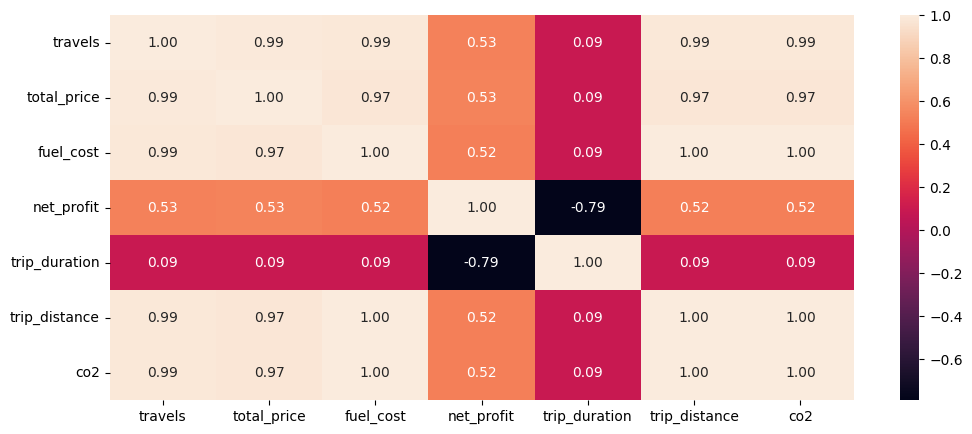

In [55]:
corr = df_hour[['travels', 'total_price', 'fuel_cost', 'net_profit', 'trip_duration',
       'trip_distance', 'co2']].corr(method='pearson')
plt.figure(figsize=(12,5))
sns.heatmap(data=corr,annot=True,fmt='.2f')
plt.show()

Se ve una correlacion casi perfecto lo que estaria indicando un posible descarte de esas variables para nuestro modelo. La unica variable en este caso relevante podria considerarse que es la ganancia neta.

# Autocorrelation

In [57]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

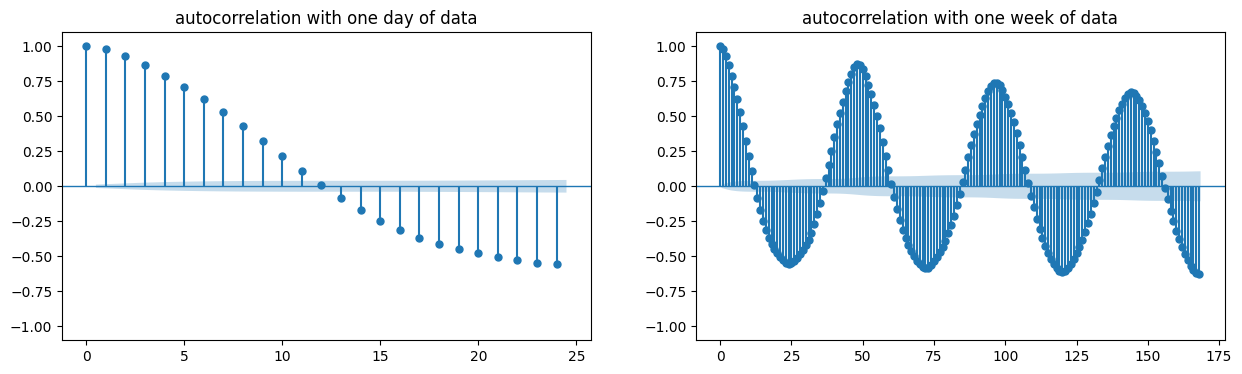

In [71]:
# Gráfico autocorrelación
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes = axes.flat
plot_acf(df_hour.travels, ax=axes[0], linewidth = 1, lags=24)
axes[0].set_title("autocorrelation with one day of data")
axes[0].set_ylim(-1.1, 1.1)
plot_acf(df_hour.travels, ax=axes[1], linewidth = 1, lags=168)
axes[1].set_title("autocorrelation with one week of data")
axes[1].set_ylim(-1.1, 1.1)
plt.show()

In [ ]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes = axes.flat
plot_pacf(df_1d.close, ax=axes[0], lags=20, method='ywm',  linewidth = 1)
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(df_1d.close, ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

## First Aproximation

In [16]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from lightgbm import LGBMRegressor

In [ ]:
lags=[1,30,90,180]
forecaster = ForecasterAutoreg(regressor=LGBMRegressor(random_state=42, verbose=-1), lags=lags)
forecaster.fit(y=df_hour['travels'])
predictions = forecaster.predict(steps=48)

In [ ]:
#df_hour.reset_index(inplace=True)
last_date = df_hour['pickup_datetime'].iloc[-1]
number_predictions = len(predictions)  # Número de predicciones futuras
future_dates = pd.date_range(start=last_date, periods=number_predictions + 1, freq='H')[1:] 
predictions = pd.DataFrame(predictions)
predictions['date'] = future_dates
predictions.columns = ['travels','date']

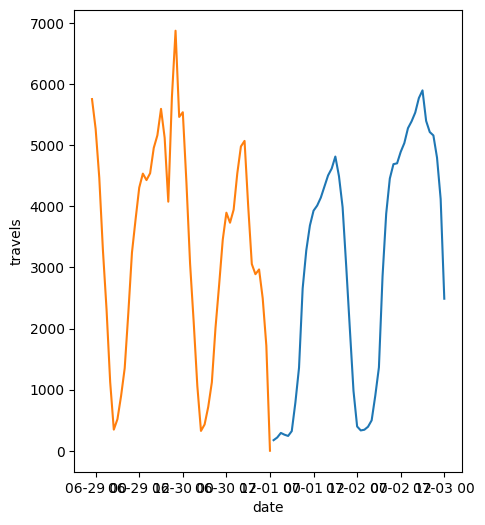

In [24]:
fig = plt.figure(figsize=(5,6))
axes = plt.axes()
sns.lineplot(data=predictions,ax=axes,x=predictions['date'],y='travels')
sns.lineplot(data=df_hour,ax=axes,x=df_hour['pickup_datetime'][-50:],y='travels')
plt.show()